# Tool to evaluate results of the scan tool

In [8]:
import os
import numpy as np
import scipy
from scipy import optimize, ndimage
import matplotlib.pyplot as plt

import extra_hed
import rossendorfer_farbenliste as rofl
from karabo_data import RunDirectory
import mmmUtils as mu

outDir='./scans/' #Directory where the results are stored 

motor="HED_IA1_DETM/MOTOR/LC_AXIS_4" #The motor which was moving 
#motor="HED_IA1_FSSS/MOTOR/SCAN_Y"

camera="HED_IA1_JF500K3/DET/JNGFR03:daqOutput" #The camera which is to be evaluated
runno=111   #RUN containing the scan
min_count=50 #minimal number of images per step to taken that step into account
rect1=np.array([20,280,400,520]) #pixel coordinates of rectangles to be evaluated
rect2=np.array([20,280,580,700])
runM=RunDirectory('/gpfs/exfel/exp/HED/202101/p002621/proc/r{:04d}'.format(runno))

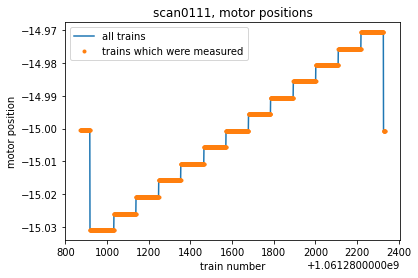

In [9]:
#Preparation: Find the motor positions, find for which there were images taken, plot it out 
prefix='scan{:04d}'.format(runno)
pos=runM.get_array(motor,"actualPosition.value")
jf =runM.get_array(camera,"data.adc")  

trainsJF  = jf.coords['trainId']
trainsPos = pos.coords['trainId']
ndx = np.searchsorted(trainsPos, trainsJF)
posSel=pos[ndx].values

plt.plot(trainsPos,pos, label='all trains')
plt.plot(trainsJF,posSel,'.',label='trains which were measured')
plt.ylabel('motor position')
plt.xlabel('train number')
plt.title(prefix +', motor positions')
plt.legend()
plt.savefig(outDir+prefix+'_positions.tif')

-15.031
-15.026
-15.021
-15.016
-15.011
-15.006
-15.001
-15.000
-14.996
-14.991
-14.986
-14.981
-14.976
-14.971


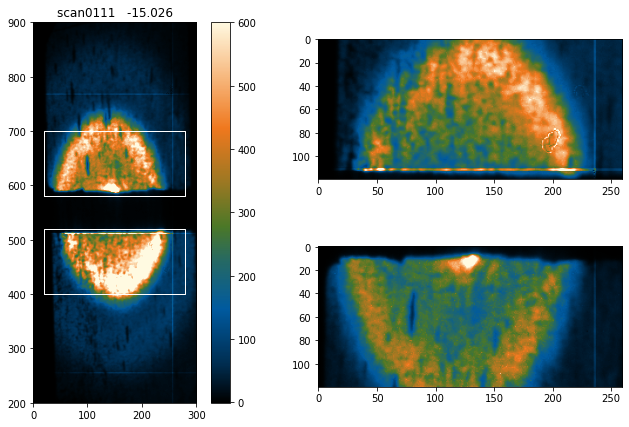

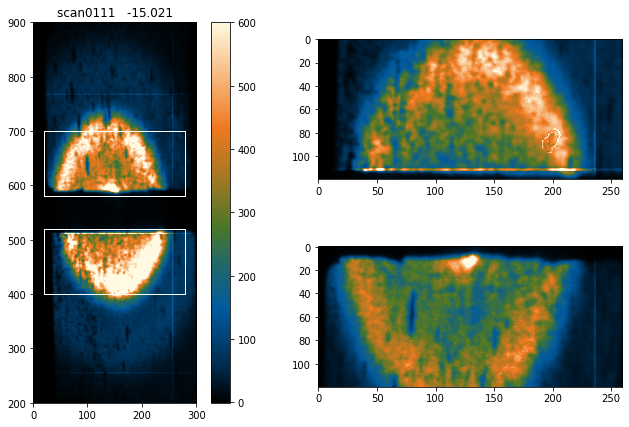

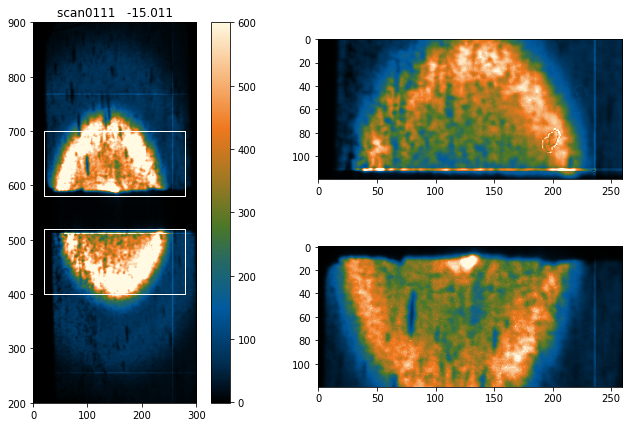

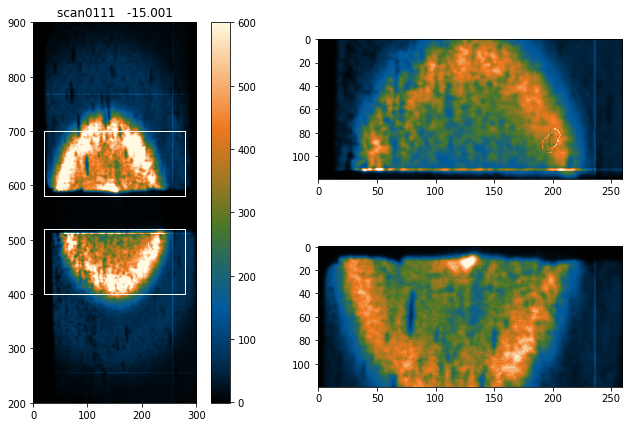

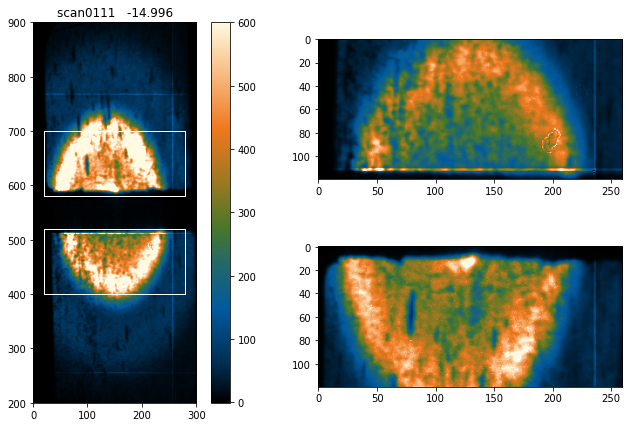

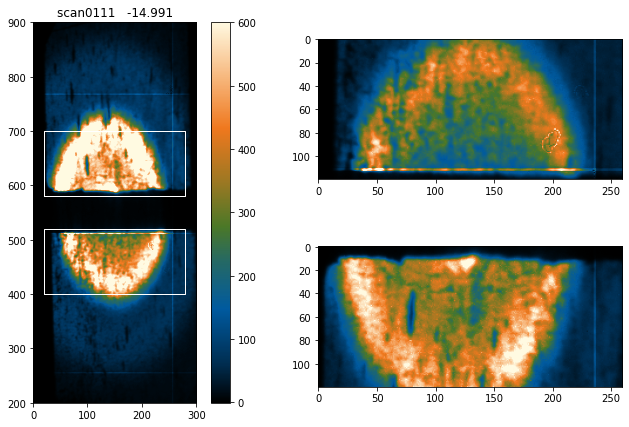

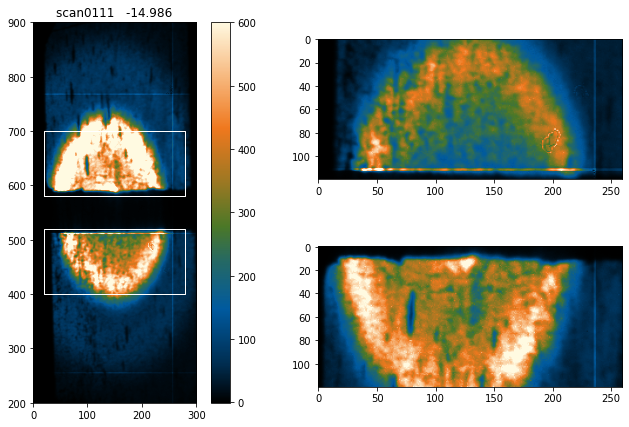

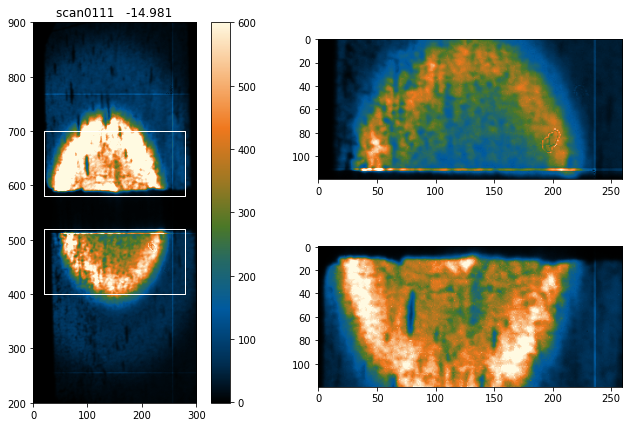

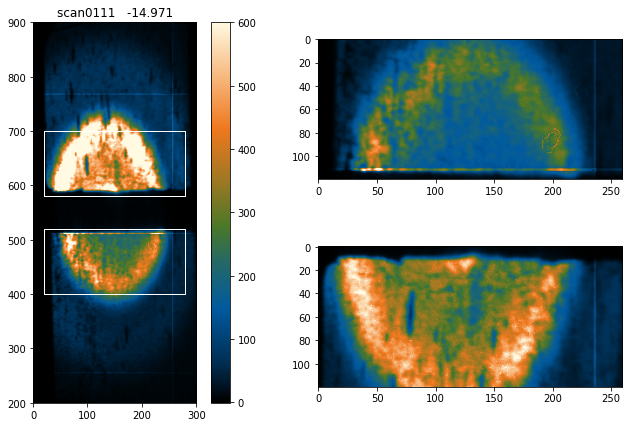

In [5]:
#Hard work: for each motor position, make an i
unq,inv=np.unique(posSel, return_inverse=1)
Ameans=np.zeros(np.shape(unq))
Bmeans=np.zeros(np.shape(unq))
nums=unq*0
for posi,pos in enumerate(unq):
    posstr="{:2.3f}".format(pos)
    print (posstr)
    nums[posi]=np.sum(posSel==pos)
    if nums[posi]<min_count:
        continue
    sel=inv==posi
    jfsel=jf[sel,0,:,:]
    jfavg=np.mean(jfsel,axis=0)
    jfavg=jfavg.transpose()
    jfA=mu.cutRect(rect1,jfavg)
    jfB=mu.cutRect(rect2,jfavg)
    #jfB=jfavg[580:700,0:300]
    Ameans[posi]=np.mean(jfA)
    Bmeans[posi]=np.mean(jfB)
    if 1:
        plt.figure()   
        plt.rcParams['figure.figsize'] = (12,7)
        plt.subplot(1,2,1)
        plt.title(prefix +'   '+ posstr)
        plt.imshow(jfavg, cmap=rofl.cmap())
        mu.drawRect(rect1)
        mu.drawRect(rect2)
        plt.colorbar()
        plt.clim(-0.5, 600)
        plt.xlim(0,300)
        plt.ylim(200,900)

        plt.subplot(2,2,2)
        plt.imshow(jfA, cmap=rofl.cmap())
        plt.clim(-0.5, 900)

        plt.subplot(2,2,4)
        plt.imshow(jfB, cmap=rofl.cmap())
        plt.clim(-0.5, 900)

        plt.savefig(outDir+prefix+'_'+posstr+'.tif')
        

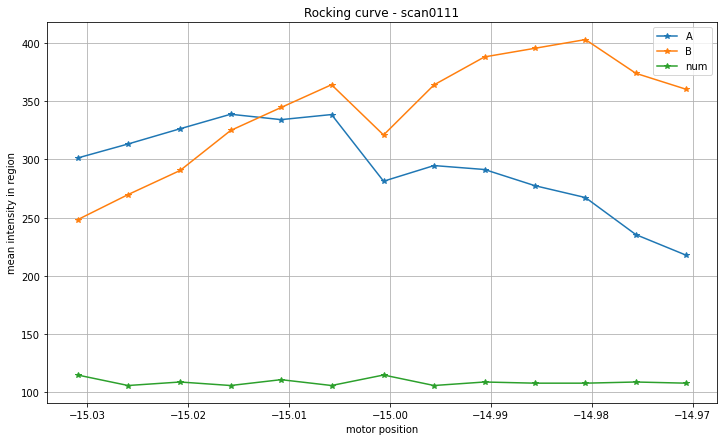

In [6]:
plt.figure()
selb=nums>=min_count
plt.rcParams['figure.figsize'] = (6,4)
plt.title('Rocking curve - '+prefix )
plt.plot(unq[selb],Ameans[selb],'*-',label='A')
plt.plot(unq[selb],Bmeans[selb],'*-',label='B')
plt.plot(unq[selb],nums[selb],'*-',label='num')

plt.grid()
plt.legend()
plt.ylabel('mean intensity in region')
plt.xlabel('motor position')
plt.savefig(outDir+prefix+'_resultB.tif')

some useful notes:

h5dump RAW-R0018-DA06-S00000.h5 | grep SCAN_Y
